In [2]:
import cv2, numpy as np
import matplotlib.pyplot as plt

blue = (0,0,255)
red  = (255,0,0)
green = (0,0,255)
white = (255,255,255)
black = (0,0,0)

def hconcat_del(arr, del_width = 5, del_clr = None, bw = 5):
    """
    modify cv2.hconcat to include vertical delimeter between images.
    """
   
    num_ch = len(arr[0].shape)
    if del_clr == None:
        if num_ch == 3:
            del_clr = [0,0,0]
        else:
            del_clr = 0

    shape = arr[0][:,:del_width].shape
    delimeter = np.full(shape = shape, fill_value=del_clr, dtype = np.uint8)

    #insert delimeter between images
    out_arr = []
    for img in arr:
        out_arr.append(img)
        out_arr.append(delimeter)

    out1 = cv2.hconcat(out_arr[:-1])
    # add border by creating a padded image and inserting inside our concat
    border_off = np.zeros(num_ch, int)
    border_off[:2] = 2*bw
    shape2 = np.array(out1.shape) + border_off
    blank = np.full(shape2, del_clr)
    blank[bw:-bw,bw:-bw] = out1
    return blank

#a = np.ones((3,3,3), np.uint8)*255
#plt.imshow(hconcat_del((a,a), del_width=1, del_clr=None, bw=1))


# Image import, convert, hconcat (horizontal concatenate)

img_gray = img_gray_convert: False


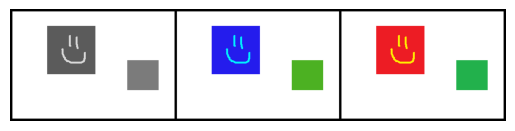

In [3]:
img_rect_path = r'../media/rect.png'
img_gray            = cv2.imread(   img_rect_path   , flags=cv2.IMREAD_GRAYSCALE)
img_bgr             = cv2.imread(   img_rect_path   , flags=cv2.IMREAD_COLOR)
img_gray_convert    = cv2.cvtColor( img_bgr         , cv2.COLOR_BGR2GRAY)  
img_rgb             = cv2.cvtColor( img_bgr         , cv2.COLOR_BGR2RGB) 
print('img_gray = img_gray_convert:', np.all(img_gray == img_gray_convert)) #  ??? why false
# in order to concat have to change to same number of channels
img_brg_gray = cv2.cvtColor(img_gray_convert, cv2.COLOR_GRAY2RGB)
plt.axis('off')

plt.imshow(hconcat_del((img_brg_gray ,img_bgr, img_rgb)))

# Binarize and Invert

138


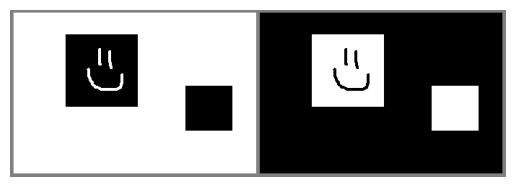

In [4]:
_, img_binary = cv2.threshold(img_gray, 150, 255, cv2.THRESH_BINARY)
img_invert = 255 - img_binary
print(np.min(img_gray))
plt.axis('off')
plt.imshow(hconcat_del((img_binary, img_invert), del_clr=128), 'gray')


# Find external contours. 

Background is black  = 0, objects are white. no black inside white

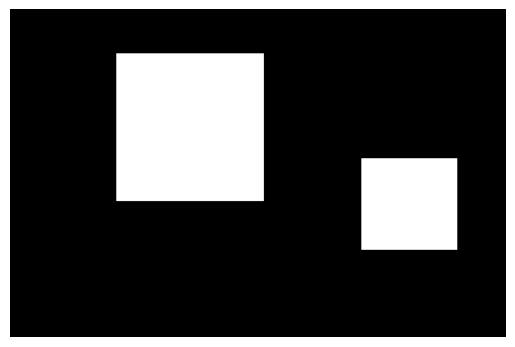

In [5]:
contours_external, _ = cv2.findContours(img_invert, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # cv2.CHAIN_APPROX_NONE

blank_ext = np.zeros_like(img_invert)

cv2.drawContours(blank_ext, contours_external, -1, 255, -1)
plt.axis('off')
plt.imshow(blank_ext, 'gray')

# Find contours with hierarchy information.
Number of rows in hierarchy = number of contours. Each row (its order numer) shows info for about its heirarchy. Last entry of each row is this contour's parent: -1  = no parent.Other values point to ID in list of contours.

[[[ 1 -1 -1 -1]
  [-1  0  2 -1]
  [ 3 -1 -1  1]
  [ 4  2 -1  1]
  [-1  3 -1  1]]]


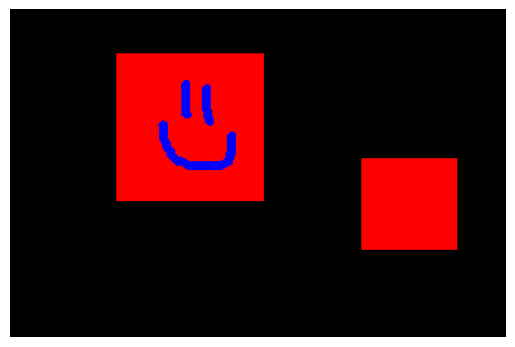

In [6]:
contours_all, hierarchy = cv2.findContours(img_invert, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
blank_all = np.zeros_like(img_rgb)
print(hierarchy)
parent_idx = hierarchy[0,:,-1]
parents_where = np.argwhere(parent_idx == -1).flatten()
childre_where = np.argwhere(parent_idx != -1).flatten()

for i, cntr in enumerate(contours_all):
    clr = red if i in parents_where else blue
    cv2.drawContours(blank_all, [cntr] , 0, clr, -1)
    
plt.axis('off')
plt.imshow(blank_all, 'gray')


# Bounding rectangles (BBoxes, also  called AABB - Axis Aligned Bounding Box) , cropping and slicing. 
Get bounding box (BB) of contours, or join multiple contours together and get combined BB.

Paste cropped elements on blank canvas via slicing

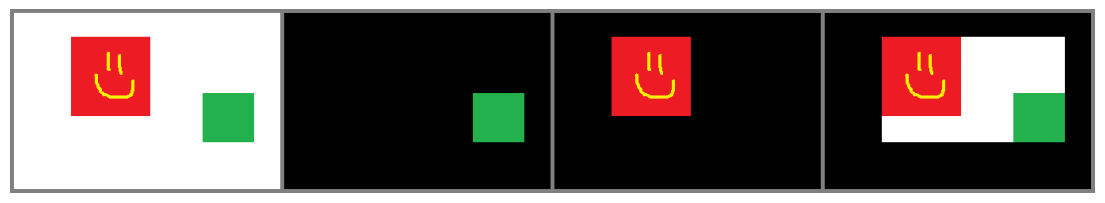

In [7]:
parent_cntrs = [cntr for i,cntr in enumerate(contours_all) if i in parents_where]
xywh_prnt   = [cv2.boundingRect(cntr) for cntr in parent_cntrs]
cropp_all   = [img_rgb[Y:Y+H,X:X+W] for X,Y,W,H in xywh_prnt]

stack_parnent_cntrs = np.vstack(parent_cntrs)

X,Y,W,H = cv2.boundingRect(stack_parnent_cntrs)
cropp_all.append(img_rgb[Y:Y+H,X:X+W])
xywh_prnt.append((X,Y,W,H ))

blank = np.zeros((4, *img_rgb.shape), np.uint8)
blank[0] = img_rgb
for i, (crop, (X,Y,W,H)) in enumerate(zip(cropp_all,xywh_prnt)):
    blank[i+1][Y:Y+H,X:X+W] = crop
fig = plt.figure(figsize= (14,9))
plt.axis('off')
plt.imshow(hconcat_del((blank), del_clr= [128,128,128]))

# Resize images/slices to a given size
Paste resize slice on top of original image

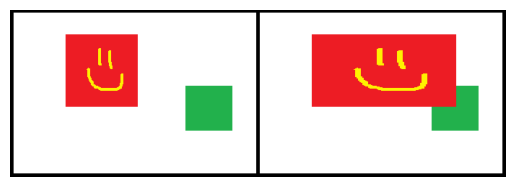

In [8]:
idx = 1
img_crop = cropp_all[idx]
X,Y,H,W = xywh_prnt[idx]
H_new, W_new = H, W*2
rect_stretched = cv2.resize(img_crop, (W_new, H_new), interpolation = cv2.INTER_AREA)
img_rgb_copy = img_rgb.copy()
img_rgb_copy[Y:Y+H_new,X:X+W_new] = rect_stretched
plt.axis('off')
plt.imshow(hconcat_del((img_rgb, img_rgb_copy)))


# Import another image, stretch it by a factors fx, fy

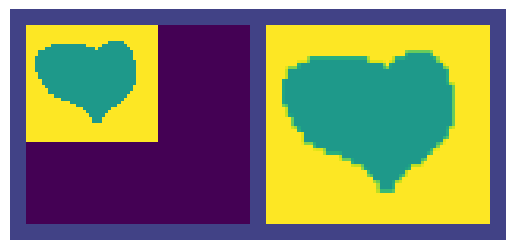

In [9]:
img_heart            = cv2.imread(r'../media/heart.png', flags=cv2.IMREAD_GRAYSCALE)
img_heart_s = cv2.resize(img_heart, dsize=None, fx = 1.7, fy= 1.7, interpolation = cv2.INTER_AREA)
_, img_heart_binary = cv2.threshold(img_heart_s, 150, 255, cv2.THRESH_BINARY)
img_heart_invert = 255 - img_heart_binary
contour_heart = cv2.findContours(img_heart_invert, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0][0]
xyhw = x,y,w,h = np.array(cv2.boundingRect(contour_heart))
contour_heart -= [[x,y]]    # make contour contact image edges
xyhw[:2] = 0                # also move bounding box to edge

H,W = img_heart.shape
H2,W2 = img_heart_s.shape
blank = np.zeros((2,H2,W2), np.uint8)
blank[0,:H,:W] = img_heart
blank[1,:H2,:W2] = img_heart_s

plt.axis('off')
plt.imshow(hconcat_del((blank[0], blank[1]), del_clr= 50))




# Draw a contour on a slice of image with local coordinates

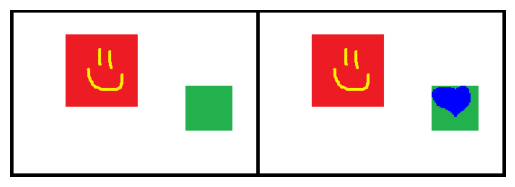

In [10]:
img_rgb_copy2 = img_rgb.copy()
X2,Y2,H2,W2 = xywh_prnt[not idx] # not 1 = 0, not 0  = 1
cv2.drawContours(img_rgb_copy2[Y2:Y2+H2,X2:X2+W2], [contour_heart] , 0, blue, -1)
plt.axis('off')
plt.imshow(hconcat_del((img_rgb,img_rgb_copy2)))

# Draw a contour on a big image with a given offset (DX,DY)

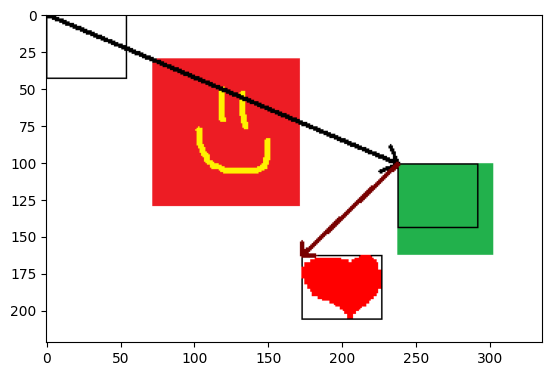

In [11]:
img_rgb_copy3 = img_rgb.copy()
xyhw_cp = xyhw.copy()
offset_zero = [0,0]
offset_corner = np.array((X2,Y2))
offset_loc = (-H2, +W2) # to the left and down
for offset in (offset_zero, offset_corner, offset_loc):
    xyhw_cp[:2] += offset 
    x,y,w,h = xyhw_cp
    cv2.rectangle(img_rgb_copy3, (x, y), (x + w, y + h), (0,0,0), 1)

cv2.arrowedLine(img_rgb_copy3, (0,0)        , offset_corner             , (0  ,0,0) , 2, tipLength=0.05)
cv2.arrowedLine(img_rgb_copy3, offset_corner, offset_corner + offset_loc, (120,0,0) , 2, tipLength=0.10)

cv2.drawContours(img_rgb_copy3, [contour_heart] , 0, red, -1, offset= offset_zero + offset_corner + offset_loc )
plt.imshow(img_rgb_copy3)

# Text stuff
comment: Its impossible to understand how thickness affects results getTextSize(). its only consistent for thc of 1 pix.

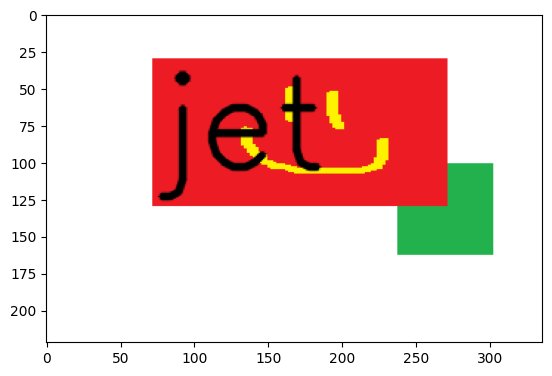

In [75]:
temp = img_rgb_copy.copy()

font = cv2.FONT_HERSHEY_SIMPLEX 
fontScale = 1
thickness = 3
thickness_offset = (thickness-1) # width = og 1 pixel width + added thickness

text = 'jet'
txt_prms = (text_width, text_height), baseLine = cv2.getTextSize(text = text, fontFace = font, fontScale = fontScale, thickness = thickness)

alpha_w = W_new / (text_width   + thickness_offset)
alpha_h = H_new / (text_height  + thickness_offset + baseLine)

alpha = min(alpha_h, alpha_w)

thickness2 = thickness*alpha
fontScale2 = fontScale*alpha
thickness_offset = int(thickness2-1)

txt_prms = (text_width, text_height), baseLine = cv2.getTextSize(text = text, fontFace = font, fontScale = fontScale2, thickness = int(thickness2))

origin = (X                     + thickness_offset//2,
          Y + H_new - baseLine  + thickness_offset//2)

cv2.putText(temp, text = text, org = origin, fontFace = font, fontScale = fontScale*alpha, color = black, thickness = thickness,  lineType = cv2.LINE_AA, bottomLeftOrigin=False)

plt.imshow(temp)

 Disregard this. its still work in progress.

half_thc 5
((46, 26), 14)


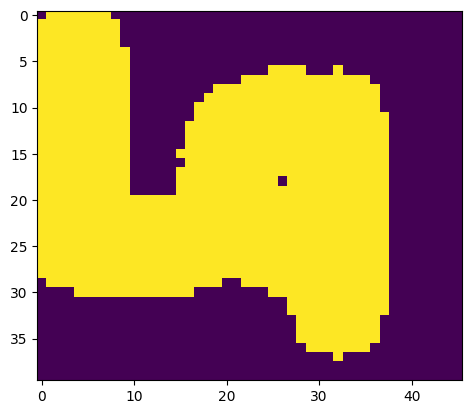

In [82]:

temp = img_rgb_copy.copy()

font = cv2.FONT_HERSHEY_SIMPLEX 
fontScale = 1
thickness = 10

half_thc = np.ceil(thickness/2).astype(int)
print('half_thc',half_thc)
thickness_offset = (thickness-1) # width = og 1 pixel width + added thickness

text = 'jet'
text = 'Lq'
txt_prms = (text_width, text_height), baseLine = cv2.getTextSize(text = text, fontFace = font, fontScale = fontScale, thickness = thickness)
print(txt_prms)
total_shape = np.array([text_height + baseLine, text_width ]) #+ thickness_offset
blank = np.zeros(shape=total_shape)

cv2.putText(blank, text = text, org = (0,baseLine), fontFace = font, fontScale = fontScale, color = white, thickness = thickness,  lineType = cv2.LINE_AA, bottomLeftOrigin=True)
plt.imshow(np.flipud(blank))
# blank_resize = cv2.resize(blank, (W_new, H_new), interpolation = cv2.INTER_AREA)

# Rotated bounding box and bounding ellipse, their centers. 
Fit tries to find such shape with which a total distance from all contour points to shape is the least. 

In some cases its not very useful.

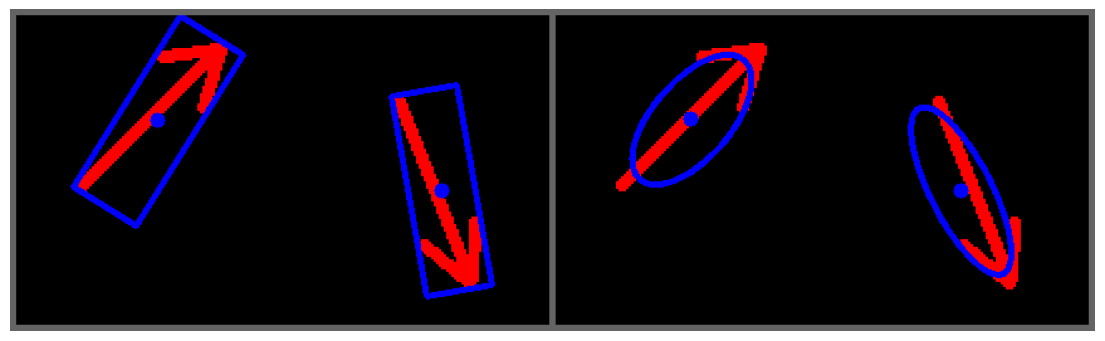

In [13]:
img = cv2.imread('../media/arrows.png',0)
img = 255 - img
scale = 2
img = cv2.resize(img, dsize=None, fx = scale, fy= scale, interpolation = cv2.INTER_AREA)

cntrs_arrows = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]

img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
blank = np.zeros_like(img)
rotated_bb = [cv2.minAreaRect(cnt) for cnt in cntrs_arrows]
centers_rbb = [np.array(c, int) for c,_,_ in rotated_bb]

rotated_ell = [cv2.fitEllipse(cnt) for cnt in cntrs_arrows]
centers_ell  = [np.array(a[0],int) for a in rotated_ell]

cv2.drawContours(blank, cntrs_arrows, -1, red, -1)

blank_bb    = blank.copy()
blank_ell   = blank.copy()

clr_center = blue
clr_bound = green
r_circle = int(scale*3)
shape_thc = int(scale*2)

boxes = [np.intp(cv2.boxPoints(b)) for b in rotated_bb]
cv2.drawContours(blank_bb, boxes, -1, clr_bound, shape_thc)
[cv2.circle(blank_bb, c, r_circle, clr_center, -1) for c in centers_rbb] 

[cv2.ellipse(blank_ell, ell, clr_bound, shape_thc) for ell in rotated_ell]
[cv2.circle(blank_ell, c, r_circle, clr_center, -1) for c in centers_ell]

fig = plt.figure(figsize= (14,9))
plt.axis('off')
plt.imshow(hconcat_del([blank_bb,blank_ell], del_clr=[100,100,100]))


# Hull of contours. Sometimes its better to fit only external contour's points.

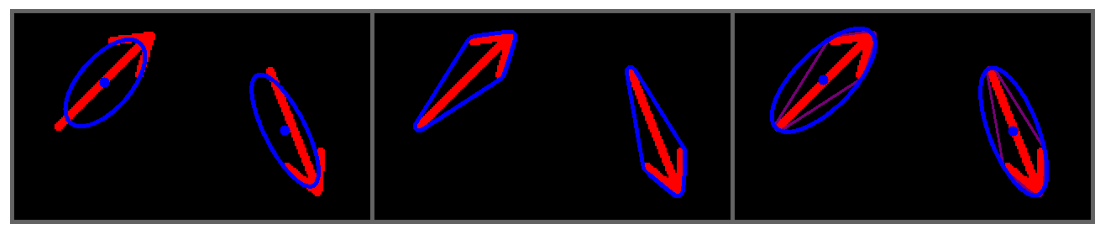

In [14]:
cntr_hulls  = [cv2.convexHull(cntr) for cntr in cntrs_arrows]
rotated_ell = [cv2.fitEllipse(cnt)  for cnt in cntr_hulls]

blank_ell_base   = blank.copy()

img1 = blank_ell_base.copy()
cv2.drawContours(img1, cntr_hulls, -1, clr_bound, shape_thc)
img2 = blank_ell_base.copy()
cv2.drawContours(img2, cntr_hulls, -1, (120,0,120), 2)
[cv2.ellipse(img2, ell, clr_bound, shape_thc) for ell in rotated_ell]

centers_ell  = [np.array(a[0],int) for a in rotated_ell]
[cv2.circle(img2, c, r_circle, clr_center, -1) for c in centers_ell]

fig = plt.figure(figsize= (14,9))
plt.axis('off')
plt.imshow(hconcat_del([blank_ell,img1,img2],del_clr=[100,100,100]))

# Image moments: center of mass. 
In combination with shape fit center can find direction of anisotropy.

This can also be done using higher order moments, if you align them to eigen axis.

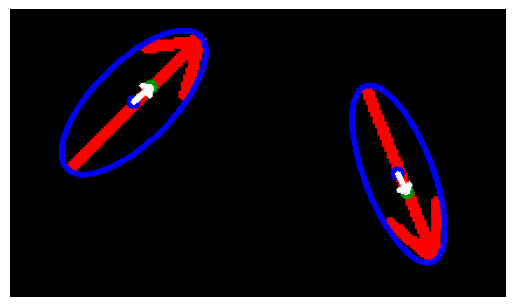

In [15]:
def calc_mom0(obj, dt = int):
    m =  cv2.moments(obj)
    return np.array((m['m10']/m['m00'], m['m01']/m['m00']), dtype = dt)

moments_arrows = [calc_mom0(crp) for crp in cntrs_arrows]
offsets_mom  = [(int(mx-cx), int(my-cy)) for ((mx,my),(cx,cy)) in zip(moments_arrows, centers_ell)]
img3 = blank.copy()
[cv2.ellipse(img3, ell, clr_bound, shape_thc) for ell in rotated_ell]
[cv2.circle(img3, c, r_circle, clr_center, -1) for c in centers_ell]
for c,off in zip(centers_ell,offsets_mom):
    cv2.circle(img3, c + off, r_circle, (0,150,0), -1) 
    cv2.arrowedLine(img3, c, c + off, white, scale*2, tipLength=scale*0.2) 

plt.axis('off')
plt.imshow(img3)
